In [1]:
from sstcam_simulation import Camera, EventAcquisition, PhotoelectronSource, SSTCameraMapping, Photoelectrons
from sstcam_simulation.camera.pulse import GenericPulse
from sstcam_simulation.camera.spe import SiPMPrompt, PerfectPhotosensor
from sstcam_simulation.camera.coupling import ACOffsetCoupling
from sstcam_simulation.camera.noise import GaussianNoise
import numpy as np
import pandas as pd
from scipy.ndimage import convolve1d
from scipy import signal
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
n_events = 1000
window_width = 10  # ns
window_start = 60
window_end = 60 + window_width
pulse_width = 1  # ns (simulate essentially a delta function)
time = np.linspace(0, pulse_width, 2)
value = np.full(time.size, 1)

# Predicting charge fluctuations due to NSB

In [3]:
nsb_list = np.geomspace(10, 1000, 10)
opct_list = [0.1, 0.5, 0.9]
d_list = []
for nsb in tqdm(nsb_list):
    for opct in opct_list:
        pulse = GenericPulse(time, value, mv_per_pe=None)
        spectrum = SiPMPrompt(opct=opct, normalise_charge=True)
        coupling = ACOffsetCoupling(nsb_rate=nsb, pulse_area=pulse.area, spectrum_average=spectrum.average)
        camera = Camera(
            continuous_readout_duration=128,
            n_waveform_samples=128,
            mapping=SSTCameraMapping(n_pixels=1),
            photoelectron_pulse=pulse,
            photoelectron_spectrum=spectrum,
            coupling=coupling,
        )
        source = PhotoelectronSource(camera=camera)
        acquisition = EventAcquisition(camera=camera)
        
        for iev in range(n_events):
            pe = source.get_nsb(nsb)
            charge = pe.get_time_slice(window_start, window_end).get_charge_per_pixel(1)[0] - coupling.offset * window_width
            
            d_list.append(dict(
                nsb=nsb,
                opct=opct,
                enf=spectrum.excess_noise_factor,
                iev=iev,
                charge=charge,
            ))
df = pd.DataFrame(d_list)

100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


In [4]:
def prediction_nsb(nsb, enf):
    return np.sqrt(nsb * 1e6 * window_width * 1e-9 * enf)

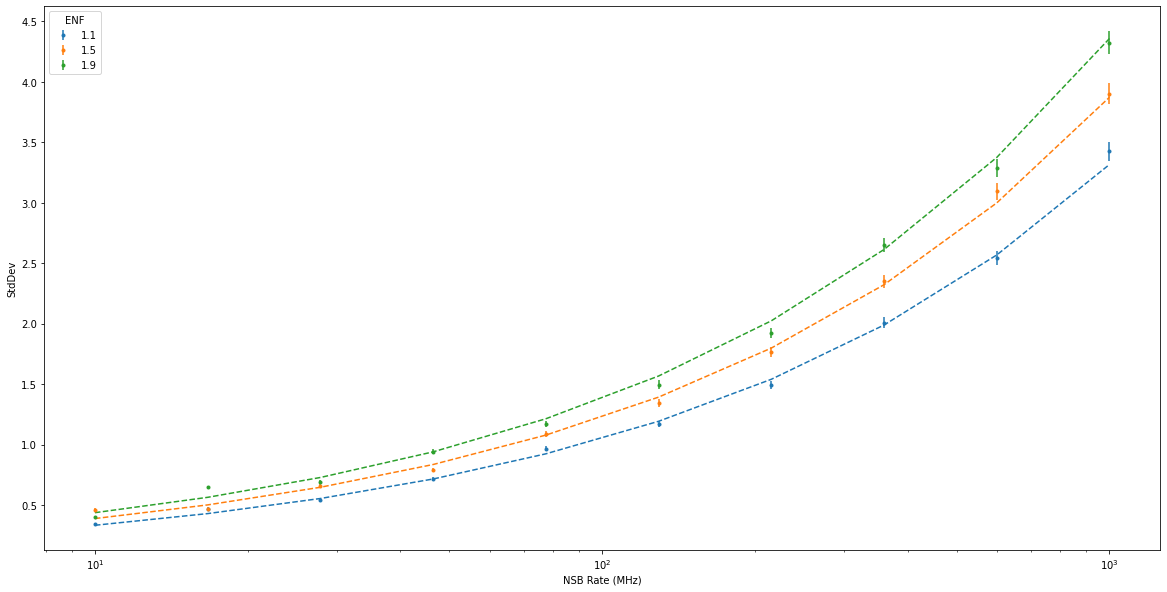

In [5]:
fig, ax = plt.subplots(figsize=(20, 10))

for enf, group in df.groupby('enf'):
    color = ax._get_lines.get_next_color()
    
    gb_nsb = group.groupby('nsb').std()
    nsb = gb_nsb.index.values
    std = gb_nsb['charge'].values
    yerr = std / np.sqrt(2 * n_events - 1)
    ax.errorbar(nsb, std, yerr=yerr, fmt='.', color=color, label=enf)
    
    std_predict = prediction_nsb(nsb, enf)
    ax.plot(nsb, std_predict, '--', color=color)
    
ax.set_xlabel("NSB Rate (MHz)")
ax.set_ylabel("StdDev")
ax.set_xscale("log")
ax.legend(title="ENF")

# Predicting charge fluctuations due to electronic/digitisation noise

In [6]:
noise_stddev_list = np.linspace(0, 10, 10)
d_list = []
for wf_stddev in tqdm(noise_stddev_list):
    noise = GaussianNoise(stddev=wf_stddev)
    camera = Camera(
        continuous_readout_duration=128,
        n_waveform_samples=128,
        mapping=SSTCameraMapping(n_pixels=1),
        digitisation_noise=noise,
    )
    source = PhotoelectronSource(camera=camera)
    acquisition = EventAcquisition(camera=camera)

    for iev in range(n_events):
        pe = Photoelectrons.empty()
        readout = acquisition.get_continuous_readout(pe)
        waveform = acquisition.get_sampled_waveform(readout)
        charge = waveform[0, window_start:window_end].sum()

        d_list.append(dict(
            wf_stddev=wf_stddev,
            iev=iev,
            charge=charge,
        ))
df = pd.DataFrame(d_list)

100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


In [7]:
def prediction_noise(stddev):
    return stddev * np.sqrt(window_width)

Text(0, 0.5, 'Charge StdDev')

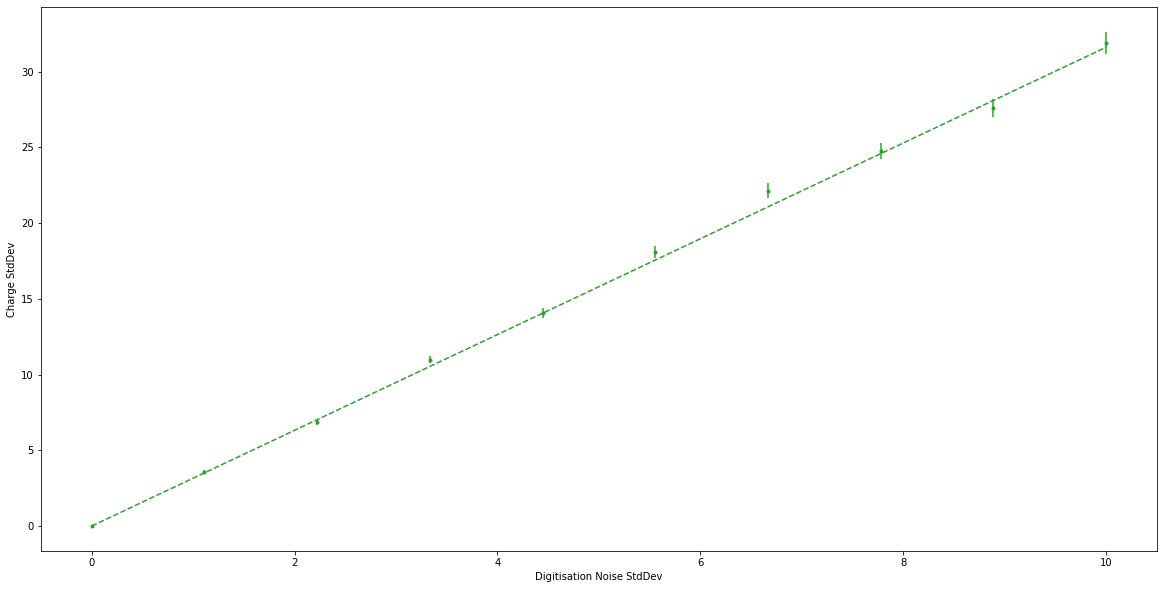

In [8]:
fig, ax = plt.subplots(figsize=(20, 10))
    
gb_wf_stddev = df.groupby('wf_stddev').std()
wf_stddev = gb_wf_stddev.index.values
std = gb_wf_stddev['charge'].values
yerr = std / np.sqrt(2 * n_events - 1)
ax.errorbar(wf_stddev, std, yerr=yerr, fmt='.', color=color)
    
std_predict = prediction_noise(wf_stddev)
ax.plot(wf_stddev, std_predict, '--', color=color)
    
ax.set_xlabel("Digitisation Noise StdDev")
ax.set_ylabel("Charge StdDev")

# Predicting total charge fluctuations due to noise

In [9]:
noise_stddev_list = [0.1, 0.5]
nsb_list = np.geomspace(10, 1000, 10)
opct_list = [0.1, 0.5, 0.9]
d_list = []
for nsb in tqdm(nsb_list):
    for opct in opct_list:
        for wf_stddev in noise_stddev_list:
            noise = GaussianNoise(stddev=wf_stddev)
            spectrum = SiPMPrompt(opct=opct, normalise_charge=True)
            coupling = ACOffsetCoupling(nsb_rate=nsb, pulse_area=pulse.area, spectrum_average=spectrum.average)
            camera = Camera(
                continuous_readout_duration=128,
                n_waveform_samples=128,
                mapping=SSTCameraMapping(n_pixels=1),
                photoelectron_pulse=pulse,
                photoelectron_spectrum=spectrum,
                coupling=coupling,
                digitisation_noise=noise,
            )
            source = PhotoelectronSource(camera=camera)
            acquisition = EventAcquisition(camera=camera)

            for iev in range(n_events):
                pe = source.get_nsb(nsb)
                readout = acquisition.get_continuous_readout(pe)
                waveform = acquisition.get_sampled_waveform(readout)
                charge = waveform[0, window_start:window_end].sum()

                d_list.append(dict(
                    nsb=nsb,
                    opct=opct,
                    wf_stddev=wf_stddev,
                    enf=spectrum.excess_noise_factor,
                    iev=iev,
                    charge=charge,
                ))
df = pd.DataFrame(d_list)

100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


In [10]:
def prediction_total(nsb, enf, stddev):
    return np.sqrt(prediction_nsb(nsb, enf)**2 + prediction_noise(stddev)**2)

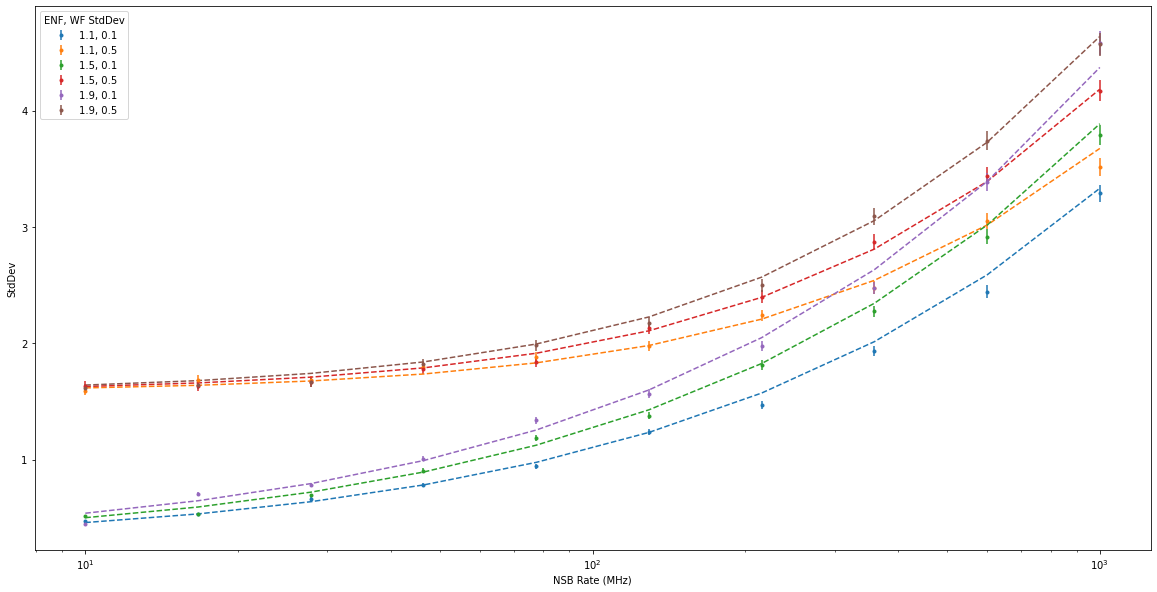

In [11]:
fig, ax = plt.subplots(figsize=(20, 10))

for (enf, wf_stddev), group in df.groupby(['enf', 'wf_stddev']):
    color = ax._get_lines.get_next_color()
    
    gb_nsb = group.groupby('nsb').std()
    nsb = gb_nsb.index.values
    std = gb_nsb['charge'].values
    yerr = std / np.sqrt(2 * n_events - 1)
    ax.errorbar(nsb, std, yerr=yerr, fmt='.', color=color, label=f"{enf}, {wf_stddev}")
    
    std_predict = prediction_total(nsb, enf, wf_stddev)
    ax.plot(nsb, std_predict, '--', color=color)
    
ax.set_xlabel("NSB Rate (MHz)")
ax.set_ylabel("StdDev")
ax.set_xscale("log")
ax.legend(title="ENF, WF StdDev")